# House Pricing Regression
In this challenge module, we will be exmaining the housing market. It is one of the most crucial parts of the economy for every country, and we will be predicting prices in the housing market using a dataset obtained off of Kaggle and hosted on the Thinkful postgres server. This particular dataset is quite well-known in Data Science literature, and we will be performing some of the standard approaches in linear, ridge, lasso, and elastic net regression. Prior to that, we will need to do a good amount of data cleaning, expoloratory data analysis, and feature engineering. We will then improve our model based off evaluation metrics and comment on our improvements.

We will follow the steps outlined by Thinkful to help us in this project:

1. Load the houseprices data from Thinkful's database.
2. Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But make sure that your work is satisfactory.
3. Now, split your data into train and test sets where 20% of the data resides in the test set.
4. Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one!
5. Evaluate your best model on the test set.
6. So far, you have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.

### 0. Libraries and Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV

In [2]:
import warnings
warnings.filterwarnings('ignore')

### 1. Importing the Dataset

In [3]:
from sqlalchemy import create_engine

In [4]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [5]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_prices_df = pd.read_sql_query('select * from houseprices',con=engine)

In [6]:
engine.dispose()

### 2. Exploratory Data Analysis (EDA), Data Preprocessing, and Feature Engineering

In [7]:
house_prices_df.sample(5)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
1114,1115,20,RL,90.0,5400,Pave,None,Reg,Lvl,AllPub,...,0,None,MnPrv,None,0,8,2006,WD,Normal,117000
1337,1338,30,RM,153.0,4118,Pave,Grvl,IR1,Bnk,AllPub,...,0,None,None,None,0,3,2006,WD,Normal,52500
222,222,60,RL,NaN,8068,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2009,ConLI,Normal,200000
610,611,60,RL,NaN,11050,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2009,WD,Normal,313000
785,786,20,RL,NaN,9790,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,9,2009,WD,Normal,161500


In [8]:
house_prices_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
mssubclass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
lotfrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
lotarea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
overallqual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
overallcond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
yearbuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
yearremodadd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
masvnrarea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
bsmtfinsf1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


### Visualizations

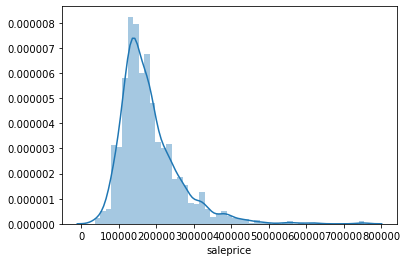

In [9]:
sns.distplot(house_prices_df['saleprice'])
plt.show()

In [10]:
print("Skewness: %f" % house_prices_df['saleprice'].skew())
print("Kurtosis: %f" % house_prices_df['saleprice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


Our distribution of sale price deviates from a normal distribution and has a skewness to the right. We would therefore look to transform our saleprice variable as we have done in previous modules with a $\log{(x+1)}$ trasnformation.

In [11]:
house_prices_df['saleprice'] = np.log1p(house_prices_df['saleprice'])

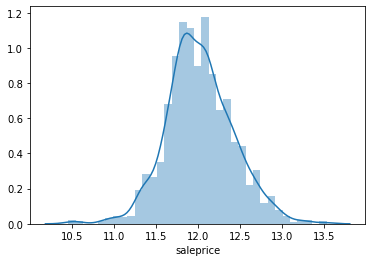

In [12]:
sns.distplot(house_prices_df['saleprice'])
plt.show()

In [13]:
print("Skewness: %f" % house_prices_df['saleprice'].skew())
print("Kurtosis: %f" % house_prices_df['saleprice'].kurt())

Skewness: 0.121347
Kurtosis: 0.809519


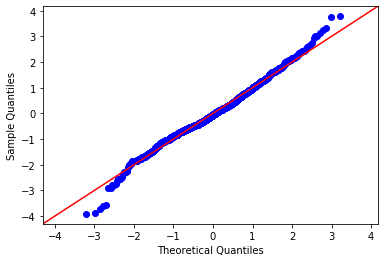

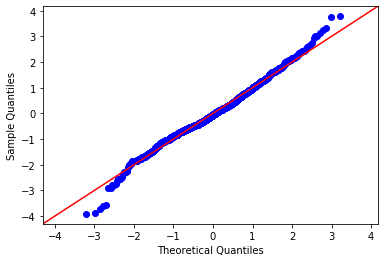

In [14]:
sm.qqplot(house_prices_df['saleprice'], fit=True, line='45')

From our qq-plot above, we see that our transformed variable roughly follows a normal distribution.

Let's take a look at the correlation matrix:

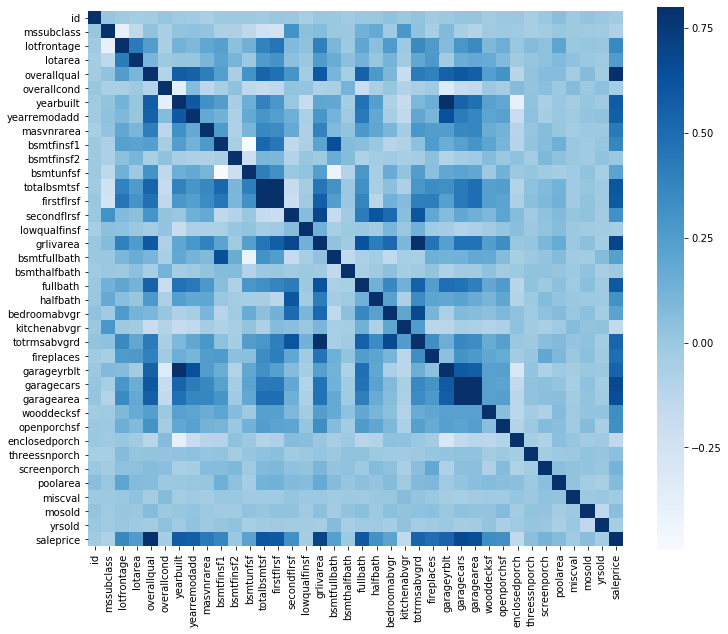

In [15]:
plt.figure(figsize=(12,10))
sns.heatmap(house_prices_df.corr(), square=True, cmap='Blues', vmax=0.8)
plt.show()

We see some correlations between variables, such as between garage variables with each other and grlivarea and the number of rooms. This makes sense. However, the high correlations itself does not warrant removal from the dataset - we would be hesitant to throw away variables based solely on this alone.

Let's also take a look at some boxplots with relation to saleprice:

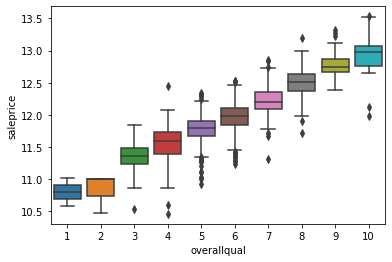

In [16]:
sns.boxplot(x='overallqual', y='saleprice', data=house_prices_df)
plt.show()

We notice that there are some outliers in our dataset here when plotting overall quality and sale price.

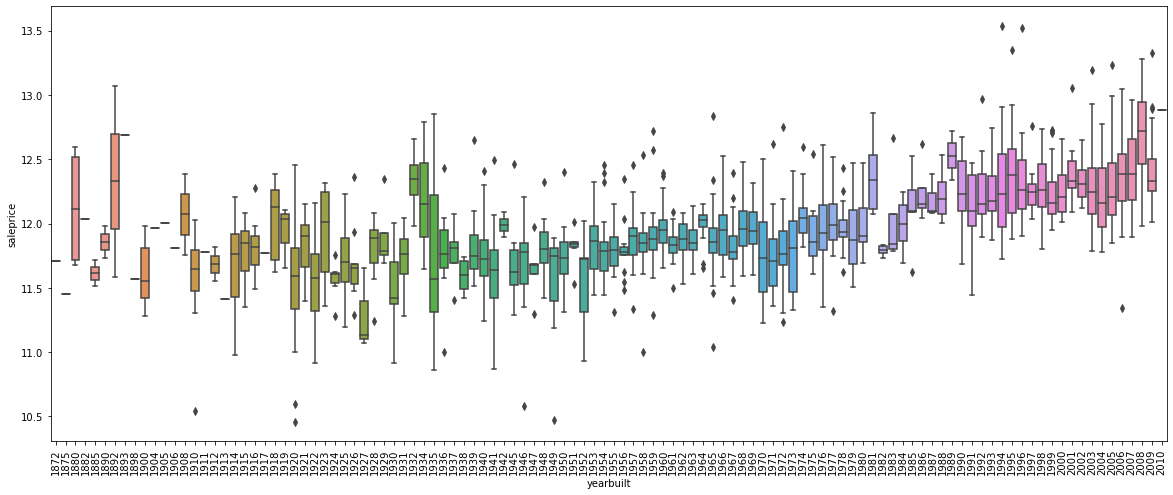

In [17]:
plt.figure(figsize=(20, 8))
sns.boxplot(x='yearbuilt', y='saleprice', data=house_prices_df)
plt.xticks(rotation=90)
plt.show()

Again, plotting sale prices versus the year built gives us a sense that there are a good number of outliers in our dataset.

Let's take a final look at some of the highly correlated features and their scatter plots in relation to saleprice:

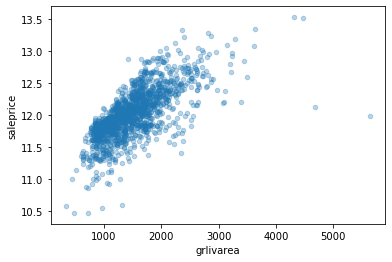

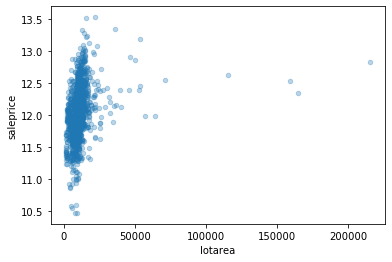

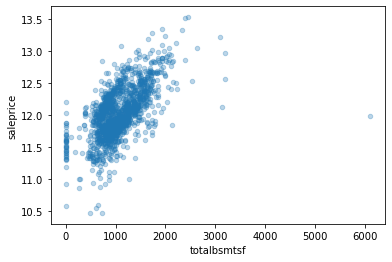

In [18]:
house_prices_df.plot.scatter(x='grlivarea', y='saleprice', alpha=0.3)
house_prices_df.plot.scatter(x='lotarea', y='saleprice', alpha=0.3)
house_prices_df.plot.scatter(x='totalbsmtsf', y='saleprice', alpha=0.3)

plt.show()

We do see some outliers in these three major correlated variables.

### Outlier Removal
We will not do an exhaustive search through each feature for this module. We could do this for all features and consider carefully the removal of outliers, but for this challenge, I believe the following will suffice:

In [19]:
# Remove houses with overall qual less than 5 but have >$200,000 price
# Remove houses with greater living area > 4500 sqft, but less than $300000 in price
house_prices_df.drop(house_prices_df[(house_prices_df['overallqual']<5) & (house_prices_df['saleprice']>np.log1p(200000))].index, inplace=True)
house_prices_df.drop(house_prices_df[(house_prices_df['grlivarea']>4500) & (house_prices_df['saleprice']<np.log1p(300000))].index, inplace=True)
house_prices_df.reset_index(drop=True, inplace=True)

### Missing Values

In [20]:
def missing_percent(df):
    data = pd.DataFrame(df)
    df_cols = list(pd.DataFrame(data))
    dict_x = {}
    for i in range(0, len(df_cols)):
        dict_x.update({df_cols[i]: round(data[df_cols[i]].isnull().mean()*100, 2)})
    return dict_x

features = house_prices_df.drop(['saleprice'], axis=1)
missing = missing_percent(features)
missing_list = sorted(missing.items(), key=lambda x: x[1], reverse=True)

missing_df = pd.DataFrame(missing_list[0:20], columns=['feature', 'missing_percentage'])
missing_df

,feature,missing_percentage
0,poolqc,99.59
1,miscfeature,96.29
2,alley,93.75
3,fence,80.71
4,fireplacequ,47.36
5,lotfrontage,17.71
6,garagetype,5.56
7,garageyrblt,5.56
8,garagefinish,5.56
9,garagequal,5.56


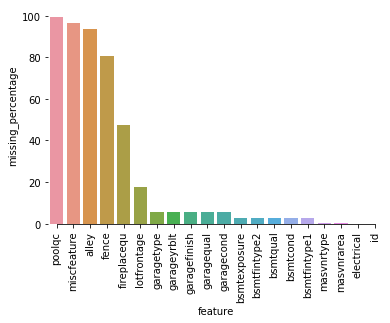

In [21]:
sns.barplot(x='feature', y='missing_percentage', data=missing_df)
plt.xticks(rotation=90)
sns.despine(trim=True, left=True)
plt.show()

For the bottom transformations and handling of missing values, I owe a lot of thanks to the many different kaggle users which I skimmed for advice on how to deal with missing values:

In [22]:
# convert some features into strings
features['mssubclass'] = features['mssubclass'].apply(str)
features['yrsold'] = features['yrsold'].astype(str)
features['mosold'] = features['mosold'].astype(str)

# replace following features' missing values with mode (manual)
features['functional'] = features['functional'].fillna('Typ')
features['electrical'] = features['electrical'].fillna('Sbrkr')
features['kitchenqual'] = features['kitchenqual'].fillna('TA')
features['mszoning'] = features.groupby('mssubclass')['mszoning'].transform(lambda x: x.fillna(x.mode()[0]))

def na_fill_mode(features_list):
    for var in features_list:
        features[var] = features[var].fillna(features[var].mode()[0])

fill_list = ['exterior1st', 'exterior2nd', 'saletype']
na_fill_mode(fill_list)

# Fill pool variable null's with "None"
features['poolqc'] = features['poolqc'].fillna('None')

# Fill garage variables with 0 - no garage, no cars
for var in ['garageyrblt', 'garagearea', 'garagecars']:
    features[var] = features[var].fillna(0)

# No garage, set null values to "None"
for var in ['garagetype', 'garagefinish', 'garagequal', 'garagecond']:
    features[var] = features[var].fillna('None')

# No basement, set null values to "None"
for var in ['bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2']:
    features[var] = features[var].fillna('None')

# Group by neighborhoods, fill missing values by median
features['lotfrontage'] = features.groupby('neighborhood')['lotfrontage'].transform(lambda x: x.fillna(x.median()))

# Replace rest of features null values with "None"
objects = []
for var in features.columns:
    if features[var].dtype == object:
        objects.append(var)
    features.update(features[objects].fillna('None'))

# Replace numeric features with "0"
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for var in features.columns:
    if features[var].dtype in numeric_dtypes:
        numeric.append(var)
    features.update(features[numeric].fillna(0))

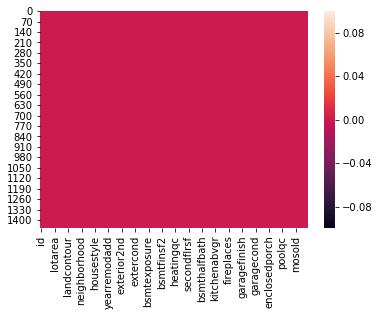

In [23]:
sns.heatmap(features.isnull())
plt.show()

We can see from our heatmap above that we have removed all of our missing values.

### Skewness of Numerical Features - Boxcox Transformation
We will apply boxcox transformations on our numerical features with high skewness.

In [24]:
numeric = []

for var in features.columns:
    if features[var].dtype in numeric_dtypes:
        numeric.append(var)

In [25]:
from scipy.stats import skew

skewed_features = features[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skewed_features[skewed_features > 0.5]
high_skew_df = pd.DataFrame(high_skew, columns=['skewness'])
print(high_skew_df)

                skewness
miscval        24.426546
poolarea       15.927003
lotarea        12.755946
threessnporch  10.282886
lowqualfinsf    8.992490
kitchenabvgr    4.478508
bsmtfinsf2      4.245879
screenporch     4.113045
bsmthalfbath    4.094248
enclosedporch   3.082631
masvnrarea      2.692486
openporchsf     2.342293
lotfrontage     1.547331
wooddecksf      1.546764
grlivarea       1.010299
bsmtunfsf       0.918905
firstflrsf      0.889179
secondflrsf     0.811079
bsmtfinsf1      0.766260
overallcond     0.690936
halfbath        0.678259
totrmsabvgrd    0.659034
fireplaces      0.631727
bsmtfullbath    0.591647
totalbsmtsf     0.512553


There are 25 numerical features with a skewness greater than 0.5. Let's normalize these features using a box-cox transformation.

In [26]:
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

for feature in high_skew.index:
    features[feature] = boxcox1p(features[feature], boxcox_normmax(features[feature] + 1))

### Encoding Categorical Features

In [27]:
features.drop(['id'], axis=1, inplace=True)

In [28]:
features = pd.get_dummies(features).reset_index(drop=True)
features.head()

,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,...,saletype_ConLw,saletype_New,saletype_Oth,saletype_WD,salecondition_Abnorml,salecondition_AdjLand,salecondition_Alloca,salecondition_Family,salecondition_Normal,salecondition_Partial
0,13.809206,9.091255,7,3.038129,2003,2003,19.455306,189.374823,0.0,30.309818,...,0,0,0,1,0,0,0,0,1,0
1,15.478223,9.220239,6,4.243781,1976,1976,0.000000,242.742427,0.0,44.679287,...,0,0,0,1,0,0,0,0,1,0
2,14.157418,9.380598,7,3.038129,2001,2002,17.788195,142.432753,0.0,57.663327,...,0,0,0,1,0,0,0,0,1,0
3,13.210360,9.214960,7,3.038129,1915,1970,0.000000,76.570648,0.0,65.721328,...,0,0,0,1,1,0,0,0,0,0
4,15.895944,9.620371,8,3.038129,2000,2000,25.437010,178.853171,0.0,62.011144,...,0,0,0,1,0,0,0,0,1,0


## 3. Split data into Training and Testing Sets

In [29]:
X = features
y = house_prices_df['saleprice']

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
X_train.shape

(1165, 331)

In [32]:
X_test.shape

(292, 331)

In [33]:
y_train.shape

(1165,)

In [34]:
y_test.shape

(292,)

## 4. & 5. Lasso, Ridge, or ElasticNet Regression
We will also use k-fold cross-validation to select the best hyperparameters.

### Linear Regression (Multivariable)

In [35]:
from sklearn.linear_model import LinearRegression
lrm = LinearRegression()
lrm.fit(X_train, y_train)

y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

In [36]:
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse

print("R-squared of the model in training set is: {}".format(lrm.score(X_train, y_train)))
r2 = lrm.score(X_train, y_train)
print("Adjusted R-squared of the model in training set: {}".format((1-(1-r2)*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1)))))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in training set is: 0.9565459868640909
Adjusted R-squared of the model in training set: 0.9392791461102062
-----Test set statistics-----
R-squared of the model in test set is: 0.8986380812367785
Mean absolute error of the prediction is: 0.08053386263249858
Mean squared error of the prediction is: 0.016648404400743128
Root mean squared error of the prediction is: 0.1290286960359715
Mean absolute percentage error of the prediction is: 0.6809216593526917


Our results from a base OLS Regression Model is not bad, with an R-squared value arriving at 0.957 and a R-squared on a our test-set of 0.899. This does seem to point at some overfitting on our training set, but overall not a bad result. Let's also try this with statsmodels.api:

### Lasso Regression
We will now use regularization regression approaches, including a number of alphas that we will implement during our cross validation to find the best hyperparameters:

In [37]:
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

In [38]:
from sklearn.linear_model import LassoCV
lasso_cv = LassoCV(alphas=alphas, cv=5)
lasso_cv.fit(X_train, y_train)

y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

In [39]:
print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train)))
r2 = lasso_cv.score(X_train, y_train)
print("Adjusted R-squared of the model in training set: {}".format((1-(1-r2)*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1)))))
print("\n-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 0.001
R-squared of the model in training set is: 0.9370576014198232
Adjusted R-squared of the model in training set: 0.9120468764137746

-----Test set statistics-----
R-squared of the model in test set is: 0.9099193036659071
Mean absolute error of the prediction is: 0.07382109041873111
Mean squared error of the prediction is: 0.014795495976884288
Root mean squared error of the prediction is: 0.12163673777639833
Mean absolute percentage error of the prediction is: 0.6261710597577317


### Ridge Regression

In [40]:
from sklearn.linear_model import RidgeCV
ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(X_train, y_train)

y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

In [41]:
print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)))
r2 = ridge_cv.score(X_train, y_train)
print("Adjusted R-squared of the model in training set: {}".format((1-(1-r2)*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1)))))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 10.0
R-squared of the model in training set is: 0.9492366464658795
Adjusted R-squared of the model in training set: 0.9290653739331137
-----Test set statistics-----
R-squared of the model in test set is: 0.9104933271376787
Mean absolute error of the prediction is: 0.07429370752969616
Mean squared error of the prediction is: 0.01470121426822904
Root mean squared error of the prediction is: 0.1212485639841934
Mean absolute percentage error of the prediction is: 0.6302007174581209


### ElasticNet Regression

In [42]:
from sklearn.linear_model import ElasticNetCV
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)
elasticnet_cv.fit(X_train, y_train)

y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

In [43]:
print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("\nR-squared of the model in training set is: {}".format(elasticnet_cv.score(X_train, y_train)))
r2 = elasticnet_cv.score(X_train, y_train)
print("Adjusted R-squared of the model in training set: {}".format((1-(1-r2)*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1)))))
print("\n-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 0.001

R-squared of the model in training set is: 0.9439171473433016
Adjusted R-squared of the model in training set: 0.9216321242588271

-----Test set statistics-----
R-squared of the model in test set is: 0.9146732031539547
Mean absolute error of the prediction is: 0.07160129779790693
Mean squared error of the prediction is: 0.014014681622507462
Root mean squared error of the prediction is: 0.11838362058370855
Mean absolute percentage error of the prediction is: 0.6071679828418977


Based on the linear regression models above, we see that our Ridge Regression Model performs the best by looking at our R-squared values and adjusted R-squared values. We could further improve this by looking at the AIC and BIC values to ensure they are minimized in information loss.

## 5. Addition of Extra Features
While we could add outside features that are not in the dataset that would probably help our model (e.g. economic factors, interest rates), what we can do instead is to use combinations of features to create interesting features. We will help our model by creating a few of these new features based on intuition on the dataset.

In [44]:
# New features created

# Total square-foot variable
features['totalsf'] = features['bsmtfinsf1']+features['bsmtfinsf2']+features['firstflrsf']+features['secondflrsf']

# Total Bathrooms (half bathroom = 0.5)
features['totalbathrooms'] = features['fullbath']+(0.5*features['halfbath'])+features['bsmtfullbath']+features['bsmthalfbath']

# Total home quality
features['totalhomequal'] = features['overallqual']+features['overallcond']

Now let's add our new variables to our ridge model:

In [45]:
X = features
y = house_prices_df['saleprice']

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
from sklearn.linear_model import RidgeCV
ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(X_train, y_train)

y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

In [48]:
print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)))
r2 = ridge_cv.score(X_train, y_train)
print("Adjusted R-squared of the model in training set: {}".format((1-(1-r2)*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1)))))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 10.0
R-squared of the model in training set is: 0.9492680749271086
Adjusted R-squared of the model in training set: 0.9288530592953668
-----Test set statistics-----
R-squared of the model in test set is: 0.9106264497200067
Mean absolute error of the prediction is: 0.07421620819919245
Mean squared error of the prediction is: 0.014679349265943064
Root mean squared error of the prediction is: 0.1211583644076754
Mean absolute percentage error of the prediction is: 0.6295522812290584


There is a small improvement here with the R-squared values, but our adjusted R-squared value went down. We should be wary of including too many features as it is penalized. We might consider back elmination to remove insignificant variables for ridge regression, but it shouldn't make a significant difference as coefficients can get relatively close to 0. We can look into creating new features, and new combinations to further improve our model.